In [2]:
import os
import glob
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional: nicer plots
plt.style.use('ggplot')

print("OpenCV version:", cv2.__version__)


OpenCV version: 4.12.0


In [3]:
# === IMPORTANT: CHANGE THIS TO YOUR DATASET ROOT FOLDER ===
DATA_DIR = r"dataset"  # e.g. r"C:/Users/you/Downloads/FacialAgingDataset"

# Class names as required in the project statement
CLASS_NAMES = ["wrinkles", "dark_spots", "puffy_eyes", "clear_skin"]

# Supported image extensions
IMG_EXTENSIONS = ["*.jpg", "*.jpeg", "*.png", "*.bmp"]

print("Dataset root:", DATA_DIR)
print("Classes:", CLASS_NAMES)

Dataset root: dataset
Classes: ['wrinkles', 'dark_spots', 'puffy_eyes', 'clear_skin']


In [4]:
def collect_images_from_folder_auto(root_dir, img_patterns):
    records = []
    for cls in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(class_dir):
            continue

        count_for_class = 0
        for pattern in img_patterns:
            pattern_path = os.path.join(class_dir, pattern)
            for img_path in glob.glob(pattern_path):
                records.append({
                    "image_path": os.path.abspath(img_path),
                    "label": cls
                })
                count_for_class += 1
        print(f"[INFO] Found {count_for_class} images for class '{cls}'")
    return pd.DataFrame(records)

df = collect_images_from_folder_auto(DATA_DIR, IMG_EXTENSIONS)
print("\nTotal images found:", len(df))
df.head()


[INFO] Found 300 images for class 'clear_skin'
[INFO] Found 303 images for class 'dark_spots'
[INFO] Found 300 images for class 'puffy_eyes'
[INFO] Found 300 images for class 'wrinkles'

Total images found: 1203


,image_path,label
0,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
1,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
2,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
3,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
4,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin


In [5]:
exists_mask = df['image_path'].apply(os.path.exists)
missing_count = (~exists_mask).sum()
print(f"Missing files: {missing_count}")

df = df[exists_mask].reset_index(drop=True)
print("After removing missing files, total images:", len(df))


#  Remove unreadable images (cannot be loaded by cv2)
def is_readable(path):
    img = cv2.imread(path)
    return img is not None

readable_mask = df['image_path'].apply(is_readable)
unreadable_count = (~readable_mask).sum()
print(f"Unreadable images (will be dropped): {unreadable_count}")

df = df[readable_mask].reset_index(drop=True)
print("After removing unreadable files, total images:", len(df))

df.head()

Missing files: 0
After removing missing files, total images: 1203
Unreadable images (will be dropped): 0
After removing unreadable files, total images: 1203


,image_path,label
0,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
1,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
2,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
3,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
4,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin


Class counts:
label
wrinkles      300
dark_spots    303
puffy_eyes    300
clear_skin    300
Name: count, dtype: int64


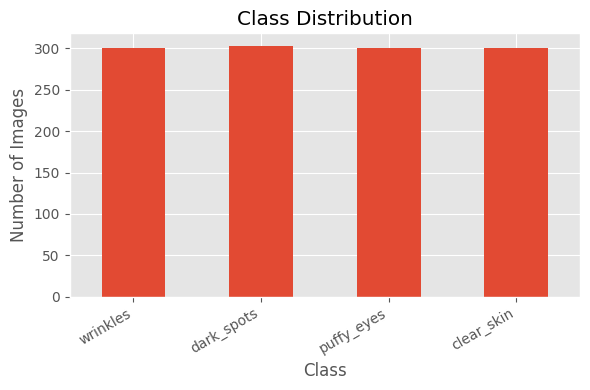

In [6]:
class_counts = df['label'].value_counts().reindex(CLASS_NAMES, fill_value=0)
print("Class counts:")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

In [7]:
# Set to True if you want to apply undersampling
APPLY_UNDERSAMPLING = False

df_balanced = df.copy()

if APPLY_UNDERSAMPLING:
    min_count = class_counts.min()
    print("Minimum samples among classes:", min_count)

    balanced_records = []
    for cls in CLASS_NAMES:
        cls_df = df[df['label'] == cls]
        if len(cls_df) > min_count:
            cls_df = cls_df.sample(min_count, random_state=42)
        balanced_records.append(cls_df)

    df_balanced = pd.concat(balanced_records).reset_index(drop=True)

    # Shuffle rows
    df_balanced = df_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)

    print("After undersampling, total images:", len(df_balanced))
    print(df_balanced['label'].value_counts().reindex(CLASS_NAMES, fill_value=0))

    # Plot new distribution
    plt.figure(figsize=(6, 4))
    df_balanced['label'].value_counts().reindex(CLASS_NAMES, fill_value=0).plot(kind='bar')
    plt.title("Balanced Class Distribution (After Undersampling)")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Undersampling NOT applied. Using original distribution.")

Undersampling NOT applied. Using original distribution.


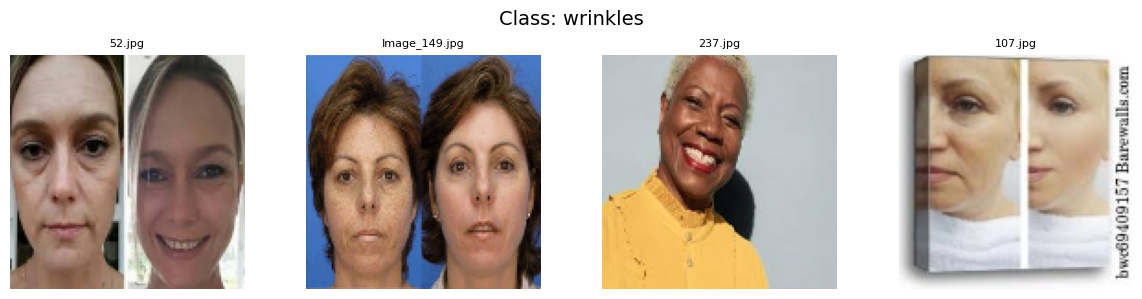

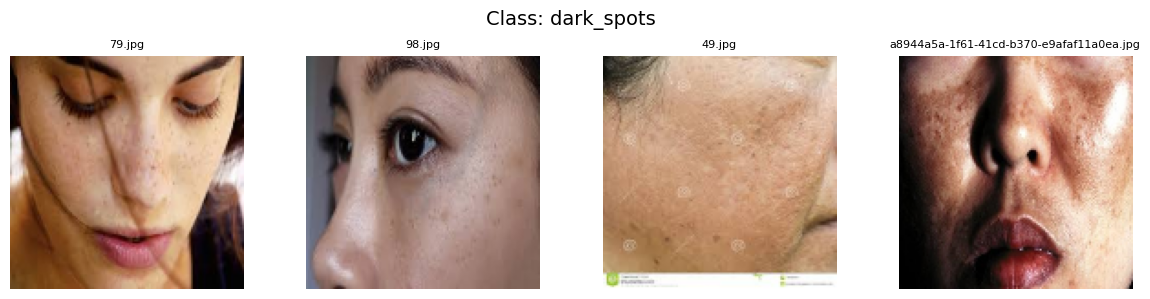

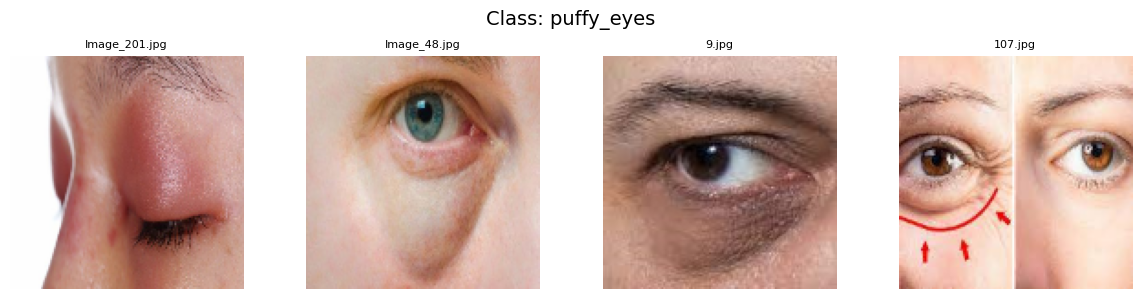

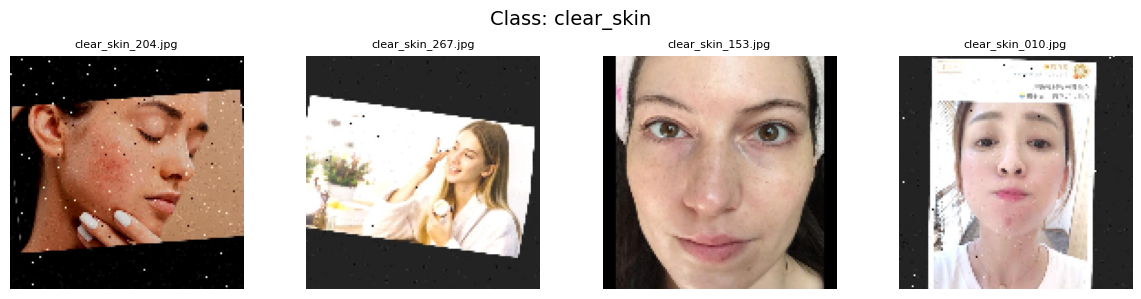

In [8]:
def show_random_images_per_class(df_labels, class_names, samples_per_class=4, img_size=(128, 128)):
    for cls in class_names:
        subset = df_labels[df_labels['label'] == cls]
        if subset.empty:
            print(f"[WARNING] No images for class '{cls}'")
            continue

        n = min(samples_per_class, len(subset))
        sample_paths = subset.sample(n, random_state=42)['image_path'].tolist()

        plt.figure(figsize=(3 * n, 3))
        plt.suptitle(f"Class: {cls}", fontsize=14)
        for i, path in enumerate(sample_paths):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)

            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(os.path.basename(path), fontsize=8)
        plt.tight_layout()
        plt.show()


# Use the balanced dataframe if undersampling is applied,
# otherwise it will just be the original cleaned df.
show_random_images_per_class(df_balanced, CLASS_NAMES, samples_per_class=4)

In [9]:
OUTPUT_CSV = "dermalscan_labels_clean.csv"

df_balanced.to_csv(OUTPUT_CSV, index=False)
print(f"Saved cleaned labeled dataset to: {OUTPUT_CSV}")
df_balanced.head()

Saved cleaned labeled dataset to: dermalscan_labels_clean.csv


,image_path,label
0,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
1,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
2,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
3,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
4,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin


In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

IMG_SIZE = (224, 224)
PROCESSED_DIR = "./processed_dataset"
os.makedirs(PROCESSED_DIR, exist_ok=True)

for cls in CLASS_NAMES:
    os.makedirs(os.path.join(PROCESSED_DIR, cls), exist_ok=True)


In [11]:
def preprocess_image(path, img_size=IMG_SIZE):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size[1], img_size[0]))
    img = img.astype(np.float32) / 255.0
    return img


In [12]:
def save_processed_dataset(df):
    new_records = []
    for idx, row in df.iterrows():
        img = preprocess_image(row["image_path"])
        if img is None:
            continue
        save_img = (img * 255).astype(np.uint8)
        filename = f"{row['label']}_{idx}.jpg"
        save_path = os.path.join(PROCESSED_DIR, row["label"], filename)
        cv2.imwrite(save_path, cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR))
        new_records.append({"image_path": os.path.abspath(save_path), "label": row["label"]})
    df_out = pd.DataFrame(new_records)
    df_out.to_csv("dermalscan_processed_labels.csv", index=False)
    return df_out


In [13]:
df_processed = save_processed_dataset(df)
df_processed.head()


,image_path,label
0,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
1,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
2,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
3,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin
4,c:\Users\capta\OneDrive\Desktop\AI_DermalScan\...,clear_skin


In [14]:
def compare_original_vs_processed(original_path, processed_path):
    o = cv2.imread(original_path)
    o = cv2.cvtColor(o, cv2.COLOR_BGR2RGB)
    p = cv2.imread(processed_path)
    p = cv2.cvtColor(p, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(o)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(p)
    plt.axis("off")
    plt.show()


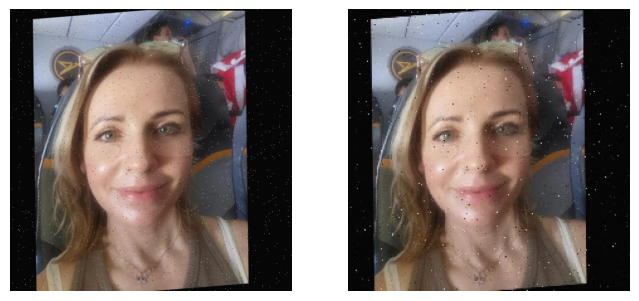

In [15]:
sample = df_processed.iloc[0]
compare_original_vs_processed(df.iloc[0]["image_path"], sample["image_path"])
